# Abstract:

<span style="color:black; font-family:Georgia; font-size:01.2em;">This report represents the solution of an entry level challenge: "When the Sakura will bloom?". Considering the life cycle of a sakura tree our task is to predict the first blooming date of Sakura in different cities. Basically following problem is solved for Tokyo city only. The first blooming day Dataset is available in Japanese Meteorological Agency website. All the problem statements are described in each section following the solution of that problem. Rule based method, chemical equation based method and a neural network is designed to predict the first blooming date. A trend of flowering phase has been mentioned where we can see the effect of climate change on the blooming date.

#### This first bloom date of Tokyo from 1961 to 2020 has been collected from the Japanese Meteorological Agency website. The actual  data is collected from following website http://www.data.jma.go.jp/sakura/data/sakura003_06.html and manipulated in .csv format for better visualization.


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('sakura_first_bloom_dates.csv')
area='Tokyo'

def get_area_wise_blooming_date(df,area=''):
    areaData=df[df['Site Name']==area].T
    yearsData=(areaData[2:-2])
    yearsData.columns=['date']
    yearsData['year'] = pd.DatetimeIndex(yearsData['date']).year
    yearsData['month'] = pd.DatetimeIndex(yearsData['date']).month
    yearsData['day'] = pd.DatetimeIndex(yearsData['date']).day
    yearsData=yearsData.drop('date',axis=1).reset_index(drop=True)
    
    return yearsData
tokyo_first_bloom_date=get_area_wise_blooming_date(df,area='Tokyo')
tokyo_first_bloom_date

,year,month,day
0,1953,3,26
1,1954,3,26
2,1955,3,24
3,1956,3,26
4,1957,4,2
...,...,...,...
63,2016,3,21
64,2017,3,21
65,2018,3,17
66,2019,3,21


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import r2_score
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from datetime import date
import calendar
import warnings
from texttable import Texttable
warnings.filterwarnings('ignore')
data=pd.read_csv('sakura.csv')
test=data.loc[(data['year']==1966)|(data['year']==1971)|(data['year']==1985)|(data['year']==1994)|(data['year']==2008)]
train=data.drop(test.index, axis=0)
attributes_name=list(data.columns)
train_year=list(train['year'].unique())
test_year=list(test['year'].unique())

print('train data shape',train.shape)
print('test data shape',test.shape)

train data shape (18718, 16)
test data shape (1826, 16)


In [3]:
train.head(10)

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6,0
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7,0
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4,0
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0,0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3,0
5,5,1961,1,6,1014.0,1014.7,0.0,0.0,0.0,3.9,8.6,-0.2,54,35,1.4,0
6,6,1961,1,7,1018.5,1019.3,0.0,0.0,0.0,3.3,9.1,-0.8,50,28,8.2,0
7,7,1961,1,8,1022.7,1023.4,0.3,0.2,0.1,4.0,11.8,-2.0,60,25,7.9,0
8,8,1961,1,9,1020.2,1020.9,7.4,2.8,0.9,4.7,6.9,1.8,69,50,0.0,0
9,9,1961,1,10,1014.9,1015.6,2.3,0.8,0.2,5.3,6.4,3.5,79,72,0.0,0


## EDA (Exploratory Data Analysis )

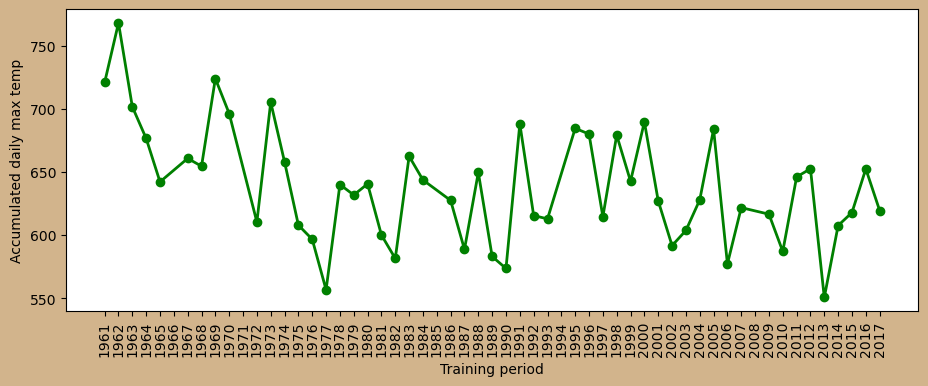

In [4]:
def day_counts(year,month,day):
    d0 = date(year, 2, 1)
    d1 = date(year, month, day)
    delta = d1 - d0
    return delta.days+1

def blooming_days_counts(blooming_date):
    blooming_days=[]
    for i in range(len(blooming_date)):
        year=int(blooming_date.iloc[i]['year'])
        month=int(blooming_date.iloc[i]['month'])
        day=int(blooming_date.iloc[i]['day'])
        blooming_days.append(day_counts(year,month,day))
    
    return blooming_days

year_range= [1966,1971,1985,1994,2008]
def predicted_blooming_date(Threshold):
    
    blooming_date=[]
    for y in year_range:
        current_year_temp = test.loc[(test['year'] ==y) &(test['month'] !=1), ['month','day','max temp']]
        current_year_temp=current_year_temp.reset_index(drop=True)
        current_year_temp.index = current_year_temp.index + 1
        temperature_sum=pd.DataFrame()
        temperature_sum['cumsum']=current_year_temp['max temp'].cumsum()
        unbloomed_days=len(temperature_sum.loc[temperature_sum['cumsum'] <=Threshold].index)
        blooming_date.append(dict(current_year_temp.iloc[unbloomed_days+1,:-1]))
    blooming_date=dict(zip(year_range,blooming_date))
    actual_blooming_date=test.loc[test['bloom'] ==1 , ['month','day']]
    actual_blooming_date['year']=year_range
    predicted_blooming_date=pd.DataFrame(blooming_date).T
    predicted_blooming_date['year']=year_range
    
    return actual_blooming_date,predicted_blooming_date

def acc_sum_of_temp_year(year,att):
    curr_year=train.loc[train['year']==year]    
    curr_year=curr_year.reset_index(drop=True)
    curr_year.index = curr_year.index + 1
    ind=list(curr_year.loc[(curr_year['year']==year) & (curr_year['bloom'] ==1)].index)
    curr_year=curr_year.iloc[31:ind[0],:]
    year_max_temp=curr_year[att].cumsum()
    acc_sum_of_temp=list(year_max_temp.tail(1).values)
    return acc_sum_of_temp[0]

def plotTemp(plot=True,att='max temp',color='g'):
    all_year_acc_sum=[]
    for y in train['year'].unique():
        all_year_acc_sum.append(acc_sum_of_temp_year(y,att))
    if plot==True:
        plt.figure(num=None, figsize=(11,4), dpi=100, facecolor='tan', edgecolor='m')
        plt.xlabel('Training period')
        plt.ylabel('Accumulated daily %s'%(att))
        plt.xticks(np.arange(1961,2018,step=1), rotation=90)
        return plt.plot(list(train['year'].unique()), all_year_acc_sum,'-bo',linewidth=2,color=color,label="Accumulated Temperature")
    
    return np.mean(all_year_acc_sum)
T_mean= plotTemp(plot=False)

plotTemp(plot=True) 

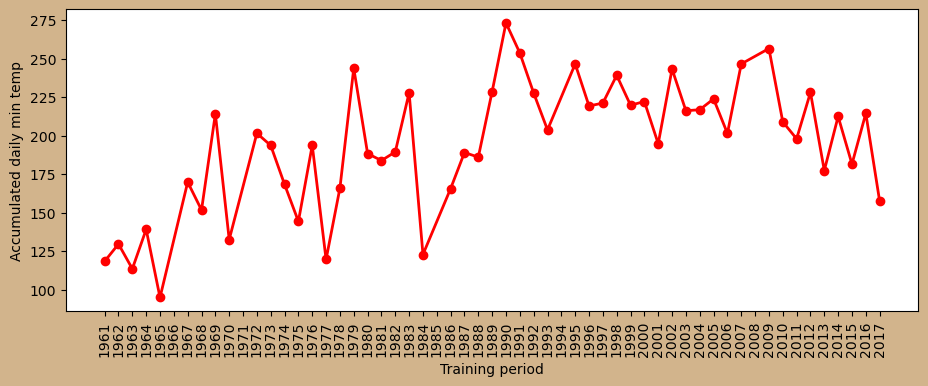

In [5]:
plotTemp(plot=True,att='min temp',color='r') 

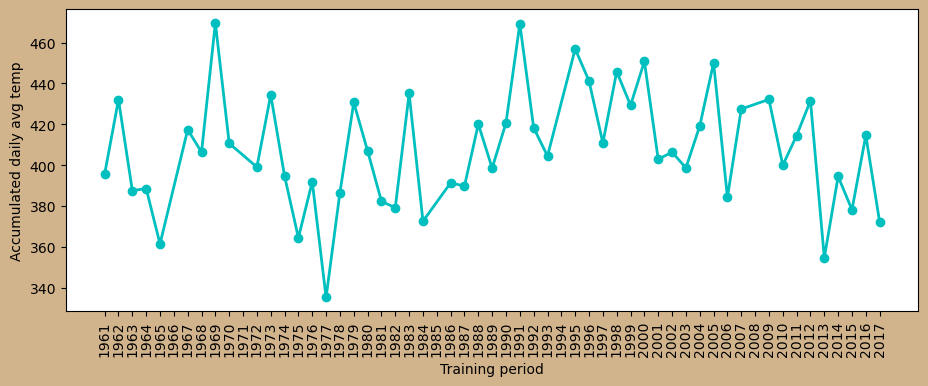

In [6]:
plotTemp(plot=True,att='avg temp',color='c') 

***
## 4. Trends of the Sakura blooming phenomenon 


Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation  and blooming  phenomena in Tokyo.

In [12]:
def Dj(year):
    degree=35
    minute=40
    phi= float(degree) + float(minute)/60
    L=4
    current_year = data.loc[(data['year'] ==year) &((data['month'] == 1)|(data['month'] == 2)|(data['month'] == 3) ), ['avg temp']]
    TF=current_year['avg temp'].mean()
    D_j= 136.75 - 7.689*phi + 0.133*(phi**2) -1.307*np.log(L) + 0.144*TF + 0.285*(TF**2)
    return D_j

D_j=[]
for year in data['year'].unique():    
    
    D_j.append((Dj(year)))
all_years= list(data['year'].unique())


In [13]:
actual_blooming_date_Tmean,predicted_blooming_date_Tmean=predicted_blooming_date(T_mean)

actual_blooming_Tmean= blooming_days_counts(actual_blooming_date_Tmean)
actual=np.asarray(actual_blooming_Tmean)+31


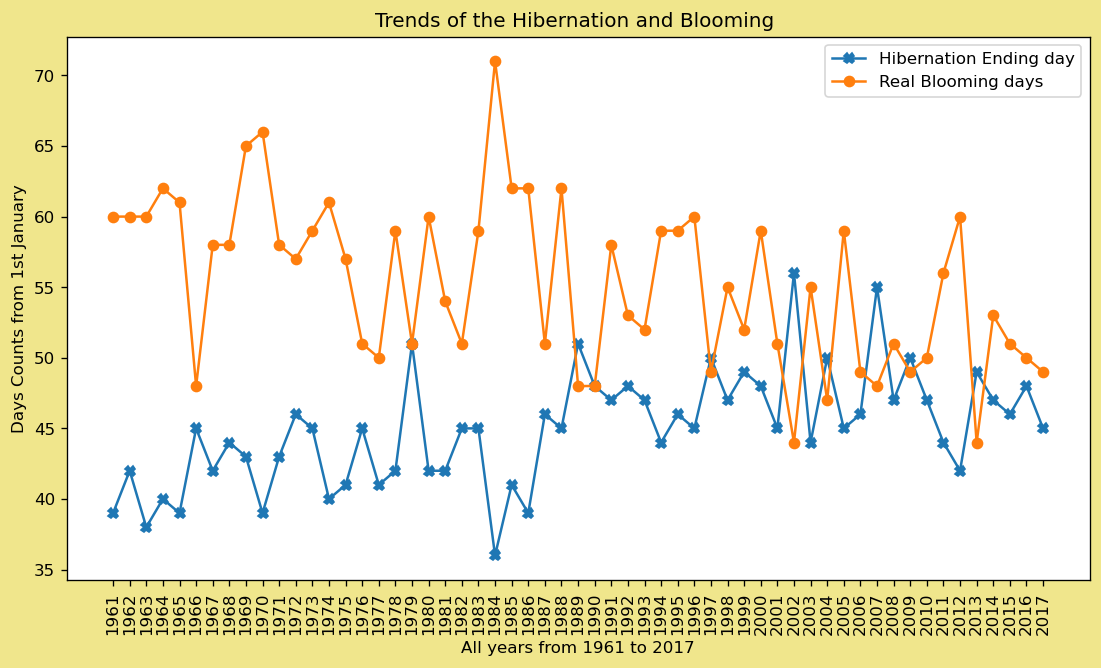

In [14]:
All_Years_Dj=[]
for each_year in all_years:
    All_Years_Dj.append(Dj(each_year))
hib_ends=np.round(All_Years_Dj) 
all_years= list(data['year'].unique())
def day_counts_all(year,month,day):
    d0 = date(year, 1, 1)
    d1 = date(year, month, day)
    delta = d1 - d0
    #print(delta.days)
    return delta.days+1

all_years_blooming_date=data.loc[data['bloom'] ==1 , ['year','month','day']]
#actual_blooming_date['year']=train_year

all_years_blooming_days=blooming_days_counts(all_years_blooming_date)

plt.figure(num=None, figsize=(11,6), dpi=120, facecolor='khaki', edgecolor='k')
plt.xlabel("All years from 1961 to 2017")
plt.ylabel("Days Counts from 1st January")
plt.title("Trends of the Hibernation and Blooming ")
plt.xticks(np.arange(1961,2018,step=1), rotation=90)
plt.yticks(np.arange(10,105,step=5), rotation=0)
plt.plot(all_years,hib_ends,"-X",label="Hibernation Ending day")
plt.plot(all_years,all_years_blooming_days,"-o",label="Real Blooming days")
plt.legend()
        
        


<span style="color:black; font-family:Georgia; font-size:1em;">From the graph above it is clearly seen that in last 25 years the hibernation ends lately. And the Blooming days is much earlier than before. This can be also visualized from the figure below where duration between end of hibernation and first blooming date has been plotted. This is the direct effect of climate change.  

<StemContainer object of 3 artists>

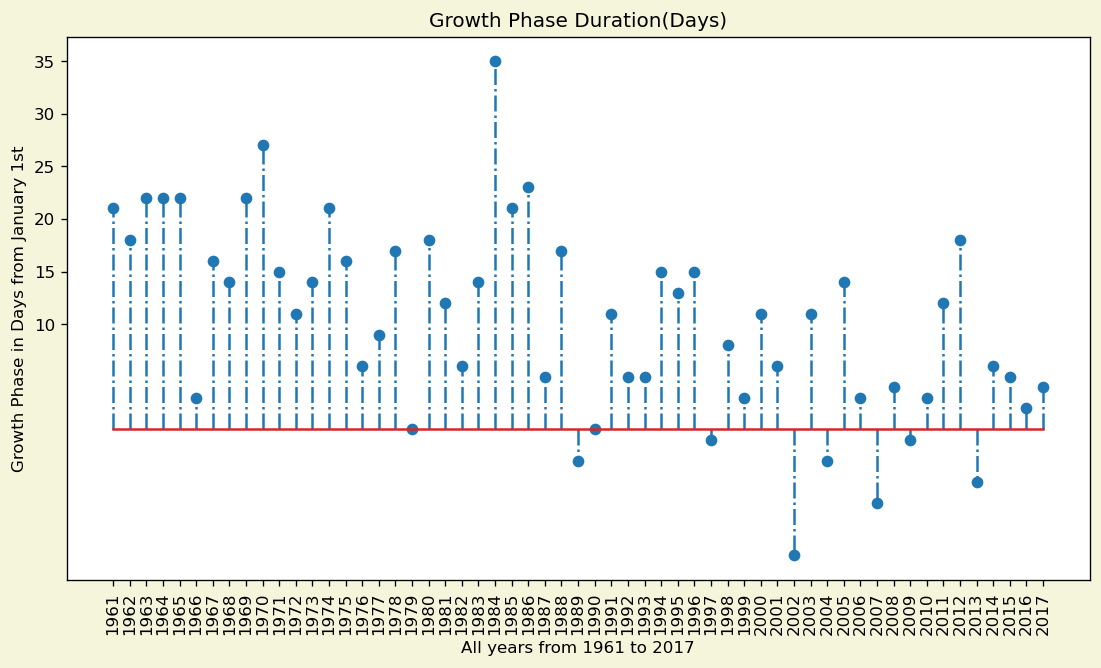

In [15]:
plt.figure(num=None, figsize=(11,6), dpi=120, facecolor='beige', edgecolor='g')
plt.xlabel("All years from 1961 to 2017")
plt.ylabel("Growth Phase in Days from January 1st")
plt.title("Growth Phase Duration(Days)")
plt.xticks(np.arange(1961,2018,step=1), rotation=90)
plt.yticks(np.arange(10,105,step=5), rotation=0)
plt.stem(all_years,np.asarray(all_years_blooming_days)-np.asarray(hib_ends),'-.',label="Growth Phase")

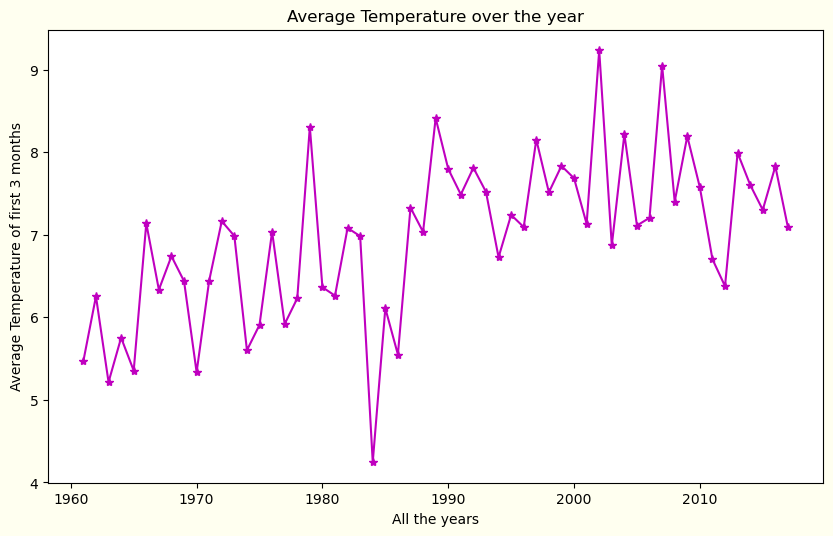

In [16]:
Average_temp=[]
for yr in all_years:
    current_year = data.loc[(data['year'] ==yr) &((data['month'] == 1)|(data['month'] == 2)|(data['month'] == 3) ), ['avg temp']]
    Average_temp.append(current_year['avg temp'].mean())
    
plt.figure(num=None, figsize=(10,6), dpi=100, facecolor='ivory', edgecolor='g')
plt.xlabel("All the years")
plt.ylabel("Average Temperature of first 3 months")
plt.title("Average Temperature over the year")
plt.plot(all_years,Average_temp, "-m*")

### Comment:: From this plot it can be seen that in recent years average temperature has increased which is direct result of global warming.

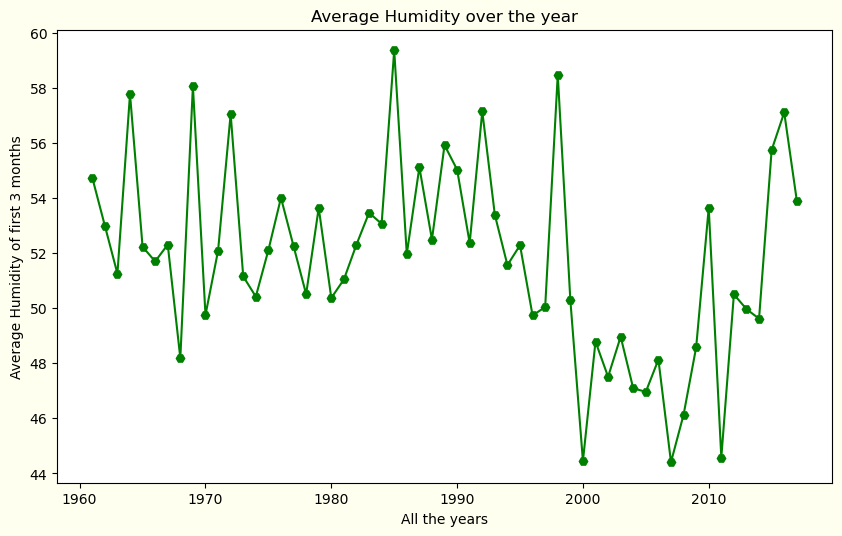

In [17]:
Average_humid=[]
for yr in all_years:
    current_year = data.loc[(data['year'] ==yr) &((data['month'] == 1)|(data['month'] == 2)|(data['month'] == 3) ), ['avg humid']]
    Average_humid.append(current_year['avg humid'].mean())
    
plt.figure(num=None, figsize=(10,6), dpi=100, facecolor='ivory', edgecolor='g')
plt.xlabel("All the years")
plt.ylabel("Average Humidity of first 3 months")
plt.title("Average Humidity over the year")
plt.plot(all_years,Average_humid, "-gH")

### Comment :: The recent trend of humidity is much less than before of 1990. As a result of low humidity bloom date is earlier in recent years.  

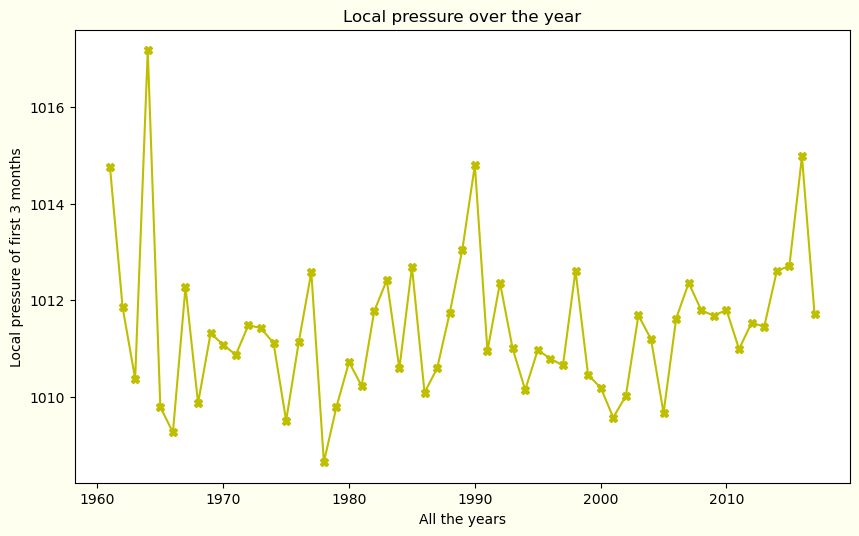

In [18]:
Average_pressure=[]
for yr in all_years:
    current_year = data.loc[(data['year'] ==yr) &((data['month'] == 1)|(data['month'] == 2)|(data['month'] == 3) ), ['local pressure']]
    Average_pressure.append(current_year['local pressure'].mean())
    
plt.figure(num=None, figsize=(10,6), dpi=100, facecolor='ivory', edgecolor='g')
plt.xlabel("All the years")
plt.ylabel("Local pressure of first 3 months")
plt.title("Local pressure over the year")
plt.plot(all_years,Average_pressure, "-yX")

In [19]:
import tensorflow as tf
data=data
test=data.loc[(data['year']==1966)|(data['year']==1971)|(data['year']==1985)|(data['year']==1994)|(data['year']==2008)]
train=data.drop(test.index, axis=0)
all_years=list(data['year'].unique())
attributes_name=list(data.columns)
train_year=list(train['year'].unique())
test_year=list(test['year'].unique())

def for_last_year():
    last_years=list(range(2000,2017,1))
    last_year=pd.DataFrame()
    for i in last_years:
        
        dum=train.loc[(train['year']==i) & (train['month'] ==4) & (train['day'] ==1)]

        dum.drop(['serial','year','month','day','bloom'],axis=1,inplace=True)
        last_year=last_year.append(dum)
        
    return last_year.mean()


def each_year_dataset(df,year):
    curr_year=df.loc[df['year']==year]    
    curr_year=curr_year.reset_index(drop=True)
    curr_year.index = curr_year.index + 1
    flag=calendar.isleap(year)*1
    if flag==0:
        ind=list(curr_year.loc[(curr_year['year']==year) &(curr_year['month'] ==4) & (curr_year['day'] ==1)].index)
    elif flag==1: 
        
        ind=list(curr_year.loc[(curr_year['year']==year) & (curr_year['month'] ==3) & (curr_year['day'] ==31)].index)
    
    curr_year=curr_year.iloc[0:ind[0],:]
    return curr_year,len(curr_year)



def Data_prep(df):
    df_target=[]
    all_data=[]
    for y in list(df['year'].unique()):
        if y==2017:
            continue
        df_chk,target=each_year_dataset(df,y)
        df_target.append(target)
        df_chk.drop(['serial','year','month','day','bloom'],inplace=True, axis=1)
        all_data.append(df_chk)
    return all_data,df_target

all_data_train=Data_prep(train)[0]
data_2017 = train.loc[train['year']==2017]
data_2017.drop(['serial','year','month','day','bloom'],inplace=True, axis=1)
data_2017=data_2017.append(for_last_year(),ignore_index=True)
all_data_train.append(data_2017)
all_data_train[5].head(5)

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours
1,1007.1,1011.6,14.0,3.5,1.0,3.3,4.1,2.1,70,56,0.0
2,1000.4,1004.7,0.0,0.0,0.0,6.3,9.5,2.4,54,39,0.6
3,1007.6,1012.0,0.0,0.0,0.0,3.5,7.6,0.3,49,28,7.5
4,1006.2,1010.6,0.0,0.0,0.0,2.1,7.5,-2.0,47,31,8.6
5,1013.4,1017.9,0.0,0.0,0.0,3.4,8.4,-2.5,45,20,8.8


## Feature Engineering::
<span style="color:black; font-family:Georgia; font-size:1em;">1. In the sense the sakura dataset is two dimensional dataset.To make it compatible  for the any neural network some feature engineering should be performed.</span> 

<span style="color:black; font-family:Georgia; font-size:1em;">2. According to H J Daunicht et al.[2] at the lower pressure transpiration is enhanced considerably, and the plants become sturdier. As a result i made a new feature named "Total pressure" just by adding the local pressure and sea pressure. An important things to be noticed that sea pressure in multiplied by a factor 0.4. The reason is sea pressure directly not affecting that particular tree rather it shows the sign of rain , humidity etc.</span>

<span style="color:black; font-family:Georgia; font-size:1em;">3. In normal sense for tropical rain forest area the higher the precipitation are, the taller and denser the vegetation is. So I added all the rainfall related feature and making a new column which depicts the total precipitation on that day.</span>

<span style="color:black; font-family:Georgia; font-size:1em;">4. Average temperature is found just by summing maximum and minimum temperature and dividing by 2 although average temperature is given in dataset.</span>

<span style="color:black; font-family:Georgia; font-size:1em;">5. . From [3] it is found that When relative humidity levels are too high or there is a lack of air circulation, a plant cannot make water evaporate or draw nutrients from the soil. When this occurs for a prolonged period, a plant eventually rots or growth phase becomes slow. As result I observed the humidity make 0 where humidity is greater than 65 this zero means growth phase becomes slower. So I let the model know that whether the blooming date will be earlier or later. But it also should be in consideration too low humidity affects the tree health as well. Because Low relative humidity harms plants' carbon absorption So for fluent growth only mid level humidity is considered only.</span>

<span style="color:black; font-family:Georgia; font-size:1em;">6. Temperature greatly affects the tree health. From the rule based approach we learned that sakura tree has characteristics that when accumulating maximum temperature cross the 600℃ mark it is tentative to bloom. So I made a new feature which represent the tentative date for blooming. This operation is implemented for average temperature. Its just let the model to know how temperature affects each training year to bloom the cherry.</span>

<span style="color:black; font-family:Georgia; font-size:1em;">7. Plants require sunlight for photosynthesis. So to accelerate the growth phase enough sunlight is required. It is good to have sun light 5-6 hours in each day. So from 1st January to 1st April we can count how much sun hours a tree is getting during this period which is our new feature[4].</span>

<span style="color:black; font-family:Georgia; font-size:1em;">8. Another important feature is air density of that particular day . This is done by following formula $\rho = \frac{P}{RT}$ where R= 287.05[J/kg K](individual gas constant) . This feature affects the blooming phenomenon to a great extent.</span>

In [20]:
def feature_enginnering(all_data):
    df=pd.DataFrame()
    whole_year_data=pd.DataFrame()
    for i in range(len(all_data)):
        df=pd.DataFrame()
        df=all_data[i][['total preci','hr1 preci','min10 preci','max temp','avg humid','avg humid','sun hours']]
        df['Total pressure']=all_data[i]['local pressure']+all_data[i]['sea pressure']*0.4   # Calculating total pressure that affecting the plant
        df['Total preci']=all_data[i]['total preci']+all_data[i]['hr1 preci']+all_data[i]['min10 preci']  # Total Rain fall for a day
        df['avg_temp']=(all_data[i]['max temp']+all_data[i]['min temp'])/2
        df['IsGrowth']=(1-(all_data[i]['min humid']>=65)*1)*3   # Tracking whether the tree gets greater humidity than 65 or not
        df['IsGrowth_fluent']=((all_data[i]['avg humid']>65) | (all_data[i]['avg humid']<35))*2
        df['IsGrowth_avg']=(1-(all_data[i]['avg humid']>=60)*1)*3
        df['enough sun']=(all_data[i]['sun hours']>=6)*1 ## Tracking Is the tree gets 6 hours of sunlight
        df['accumulated_max_sum']=((all_data[i]['max temp'].cumsum())>700)*1 # Is cumulative sum of maximum temperature greater than 700
        df['accumulated_avg_sum']=((all_data[i]['avg temp'].cumsum())>400)*1
        df['grow_time_sun']=((all_data[i]['sun hours'].cumsum())>350)*1
        df['air_den']=all_data[i]['local pressure']*(1/(287.05*all_data[i]['avg temp']))
        df['fav_air_den']=((df['air_den'].cumsum())>32)*1
        whole_year_data=whole_year_data.append(df.cumsum().tail(1))
    return whole_year_data

train_NN=feature_enginnering(all_data_train)
all_data_test=Data_prep(test)[0]
test_NN=feature_enginnering(all_data_test)
def day_counts_all(year,month,day):
    d0 = date(year, 1, 1)
    d1 = date(year, month, day)
    delta = d1 - d0
    #print(delta.days)
    return delta.days+1

def blooming_days_counts(blooming_date):
    blooming_days=[]
    for i in range(len(blooming_date)):
        year=int(blooming_date.iloc[i]['year'])
        month=int(blooming_date.iloc[i]['month'])
        day=int(blooming_date.iloc[i]['day'])
        blooming_days.append(day_counts_all(year,month,day))
    
    return blooming_days
actual_blooming_date=train.loc[train['bloom'] ==1 , ['month','day']]
actual_blooming_date['year']=train_year

blm=blooming_days_counts(actual_blooming_date)
train_NN['days']=blm

#y_true=list(actual)
y_true=list(actual)

y=train_NN['days']
X=train_NN.drop(['days'], axis=1)
#
X=X.values
y=y.values
input_dim=X.shape[1]
X=np.asarray(X,dtype=np.float32)
y=np.asarray(y,dtype=np.float32)
X_test=test_NN
X_train=X
y_train=y

scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
n_features = X_train.shape[1]
print("Total Number Of Features for the training :: ", n_features)

Total Number Of Features for the training ::  19


***
## 3. Predicting Bloom-date via Neural Network 

Epoch: 0001 cost= 7473.076416016
Epoch: 0101 cost= 12.900776575
Epoch: 0201 cost= 12.321221587
Epoch: 0301 cost= 11.900687163
Epoch: 0401 cost= 11.567202217
Epoch: 0501 cost= 11.287952169
Epoch: 0601 cost= 11.046669838
Epoch: 0701 cost= 10.834217322
Epoch: 0801 cost= 10.644704403
Epoch: 0901 cost= 10.474103839
Epoch: 1001 cost= 10.319274238
Epoch: 1101 cost= 10.177888080
Epoch: 1201 cost= 10.047989361
Epoch: 1301 cost= 9.928094294
Epoch: 1401 cost= 9.816953676
Epoch: 1501 cost= 9.713544337
Epoch: 1601 cost= 9.616983004
Epoch: 1701 cost= 9.526527186
Epoch: 1801 cost= 9.441673129
Epoch: 1901 cost= 9.361793644
Epoch: 2001 cost= 9.286446651
Epoch: 2101 cost= 9.215309247
Epoch: 2201 cost= 9.148009412
Epoch: 2301 cost= 9.084283662
Epoch: 2401 cost= 9.023833759
Epoch: 2501 cost= 8.966452487
Epoch: 2601 cost= 8.911903630
Epoch: 2701 cost= 8.860036321
Epoch: 2801 cost= 8.810688327
Epoch: 2901 cost= 8.763692877
Optimization Finished!
Predctied Days from January 1st:  [[79.0023  ]
 [89.70038 ]
 [

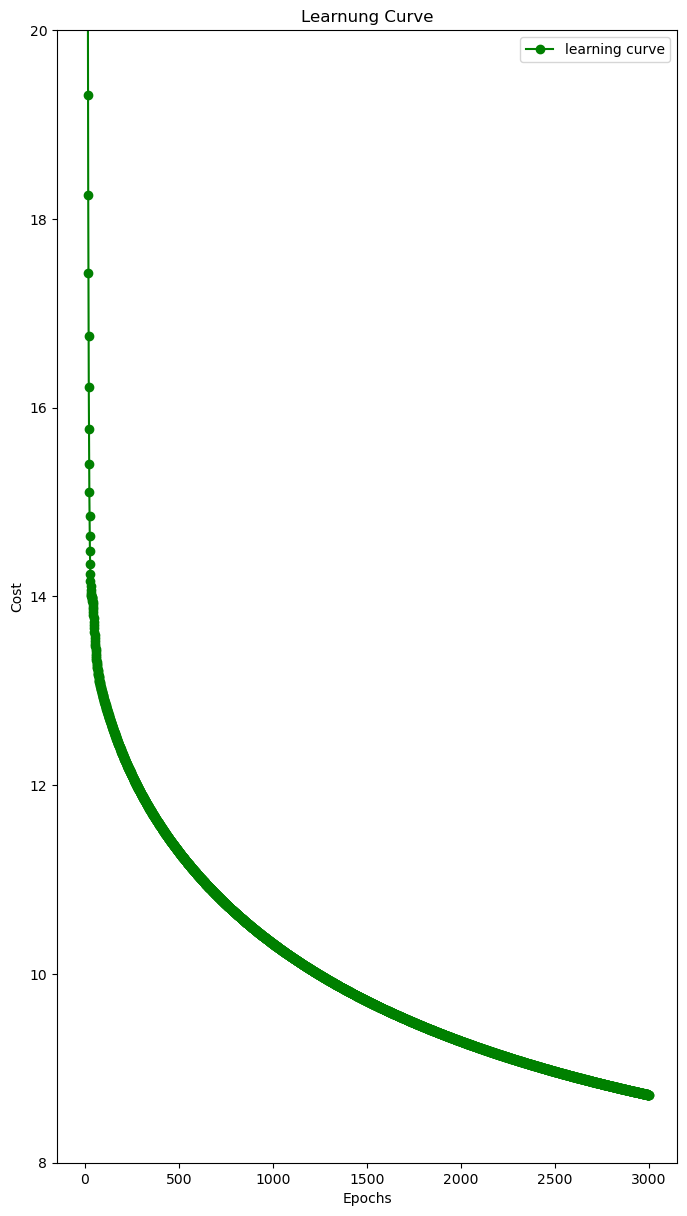

In [22]:
Xs = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
Ys = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 0.001
beta=.001
np.random.seed(1)
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="truncated_normal", scale=sigma)
bias_initializer = tf.zeros_initializer()


def W_and_b(in_size,out_size):
    
    W = tf.Variable(weight_initializer([in_size, out_size]))
    b = tf.Variable(bias_initializer([out_size]))
    return W ,b


def layer(data,in_dim,out_dim):
    W,b=W_and_b(in_dim,out_dim)
    return tf.add(tf.matmul(data, W), b) , W
    


def ANN_MODEL(X):
    input_layer,W0 = layer(Xs,n_features,30)
    input_layer=tf.nn.sigmoid(input_layer)
    # Hidden layer
    hidden_1, W1= layer(input_layer,30,20)
    hidden_1 = tf.nn.relu(hidden_1)
    
    hidden_2, W2=layer(hidden_1,20,10)
    hidden_2 = tf.nn.relu(hidden_2)
#    
#    hidden_3,W3=layer(hidden_2,200,50)
#    hidden_3=tf.nn.leaky_relu(hidden_3)
    
    
    hidden_4,W4 = layer(hidden_2,10,1)
    hidden_4=tf.transpose(hidden_4)
    out=hidden_4
     
    return out,W0,W1,W2,W4

out,W0,W1,W2,W4= ANN_MODEL(X)

parameters=[W0,W1,W2,W4]

##L2 Regularizer
def l2_regularizer(cost, l2_beta, parameters):
    regularizer = 0
    for weight in parameters:
        regularizer += tf.nn.l2_loss(weight)

    cost = tf.reduce_mean(cost + l2_beta * regularizer)

    return cost
# Cost function
loss = tf.reduce_mean(tf.squared_difference(out, Ys))


cost = l2_regularizer(loss, beta, parameters)

opt = tf.train.AdadeltaOptimizer(learning_rate=0.01).minimize(cost)


# Fitting the neural network
batch_size =1
epochs = 3000
c_t=[]
display_step=100

y_test=np.asarray(y_true,dtype=np.float32)
Avg_Cost=[]
Avg_Cost_val=[]
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        avg_cost = 0.0

        total_batch = int(len(X_train) / batch_size)
        total_batch_val=int(len(X_test) / batch_size)
        x_batches = np.array_split(X_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        x_batches_val = np.array_split(X_test, total_batch_val)
        y_batches_val = np.array_split(np.asarray(y_true,dtype=np.float32), total_batch_val)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            
            _, c = sess.run([opt, cost], 
                            feed_dict={Xs: batch_x, Ys: batch_y })
            avg_cost += c / total_batch

            if i%10==0:
                
                step = epoch * total_batch + i

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
            

        
            
        c_val = sess.run(cost, feed_dict={Xs: X_test, Ys: y_test })

        Avg_Cost_val.append(c_val)    
        Avg_Cost.append(avg_cost)
    print("Optimization Finished!")
    pred = sess.run(out, feed_dict={Xs: X_test})
    predictions=np.transpose(pred)
    
plt.figure(num=None, figsize=(8,15), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'figure.max_open_warning': 0})
plt.ylim((8,20))
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Learnung Curve')
p=plt.plot(list(range(1,epochs+1,1)),Avg_Cost,'-bo',color='g',label="learning curve")
plt.legend(handles=p,fancybox=True,loc=1)    
print('Predctied Days from January 1st: ',predictions)
print('Actual Days from January 1st: ',y_true)
print('Neural Network R2 score: ',r2_score(y_true,np.round(predictions)))

#### For huge amount of epochs the learning and validation loss curve is determined separately. Which is given below.

<h2><center><span style="color:black; font-family:Times New Roman; font-size:01.4em;"> Some Parameter tuning:</span></center></h2>

| Optimizer | learning rate | Epochs | Corresponding R^2 Score |
| --- | --- | --- | --- |
| Adam | 0.01 | 2600 | 0.1836 |
| Adam | 0.1 | 2600 |0.31 |
| Adam | 0.01 | 3000 |0.7704 |
| Gradient Descent | 0.01 | 2600 |0.0932 |
| Gradient Descent | 0.1 | 3000 |0.7711 |
| Gradient Descent | 0.1 | 3500 |0.7711 |
| AdaDelta | 0.1 | 2600 |0.8932 |
| AdaDelta | 0.01 | 3000 |0.9780 |
| AdaDelta | 0.01 | 3500 |0.9243 |

<h2><center><span style="color:black; font-family:Times New Roman; font-size:01.4em;"> Reason to choose above Model:</span></center></h2>

| Parameters |Values | Reason |
| --- | --- | --- |
| weight_initializer | Normal distribution | Assigning random values to weights is better than just assigning 0.  If weights are initialized with very high values the term np.dot(W,X)+b becomes higher. Activation function maps it to 1 gradient changes slowly and learning takes a lot of time. |
| bias_initializer | zeros | In general practice biases are initialized with 0. |
| optimizer | AdaDelta | AdaDelta is the extension of AdaGrad. It improves manual selection of learning rate.  if the initial gradients are large, they won’t affect the learning rate. AdaDelta does not focus on updating the learning rate for each step at all. |
| cost | mean square | As our problem is regression it is good practice to use mean square loss |
| Learning rate | 0.01 | In this learning rate the model learn very well. If we reduce the learning rate weight update becomes slow and in the end some under fitting problem is introduced. |
| Batch_size | 1  | We have very small amount of data if we reduce the batch size the model can learn firmly  |
| epochs | 3000 | To learn the model about 1000-1500 epochs have been used. If we increase the epochs greater than we used, overfitting problem occurs. |


+----------------+-----------+
|     Method     | R^2 Score |
+================+===========+
| Neural Network | 0.978     |
+----------------+-----------+


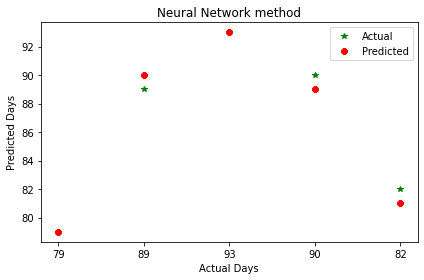

In [26]:
R2_Neural_Network=r2_score(y_true,np.round(predictions))

t = Texttable()
t.add_rows([['Method', 'R^2 Score'],['Neural Network',R2_Neural_Network]])
print(t.draw())
#plt.subplot(1,1,1)
plt.plot(y_true,"g*",label="Actual")
plt.plot(np.round(predictions),"r8",label="Predicted")
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.xticks(np.arange(5), list(map(str,y_true)))
plt.title("Neural Network method")
plt.legend()
plt.tight_layout()


# Acknowledgement
[1]. Feng, Yongsheng & LI, XIAOMET & BOERSMA, LARRY. (1990). The Arrhenius Equation as a Model for Explaining Plant Responses to Temperature and Water Stresses. Annals of Botany. 66. 10.1093/oxfordjournals.aob.a088020. 


[2]. J Daunicht, H & J Brinkjans, H. (1996). Plant responses to reduced air pressure: Advanced techniques and results. Advances in space research : the official journal of the Committee on Space Research (COSPAR). 18. 273-81. 10.1016/0273-1177(95)00889-M. 

[3]. https://polygongroup.com/en-US/blog/how-humidity-affects-the-growth-of-plants/


[4]. https://homeguides.sfgate.com/plants-really-need-6-hours-sun-per-day-71804.html


[5]. Effects of elevated pressure on rate of photosynthesis during plant growth.
Takeishi H1, Hayashi J, Okazawa A, Harada K, Hirata K, Kobayashi A, Akamatsu F.